In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#import fbprophet


In [ ]:

from sklearn.metrics import  mean_absolute_error


Описание набора данных и признаков


Датасет, полученный с Kaggle (https://www.kaggle.com/rtatman/us-candy-production-by-month ) содержит данные об уровне производства конфет в США с января 1972 по август 2017 года.

Каждая запись характеризуется двумя значениями:

observation_date - дата в формате YYYY-MM-DD
IPG3113N - индустриальный продуктовый индекс. Это универсальный индекс уровня производства, который измеряется как % от уровня производста 2012 года.
Рассматривается задача прогнозирования будущего уровня производства конфет по имеющимся предыдущим наблюдениям. В качестве горизонта прогнозирования выбран временной интервал в 24 месяца.

In [ ]:
df = pd.read_csv('candy_production.csv')

In [ ]:
df.head()

,observation_date,IPG3113N
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  548 non-null    object 
 1   IPG3113N          548 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.7+ KB


приведём данные к более удобному виду дата-время и сделаем даты индексами.

In [ ]:
df.index = pd.to_datetime(df['observation_date'], dayfirst=True )
df['value'] = df['IPG3113N']
df = df.drop(['observation_date', 'IPG3113N'], axis=1)

In [ ]:
df.head()

,value
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


Теперь проверим данные на наличие пропусков .

In [ ]:
df.isnull().sum(axis=0)

value    0
dtype: int64

Порсмотрим на гистограмму распределения выпуска

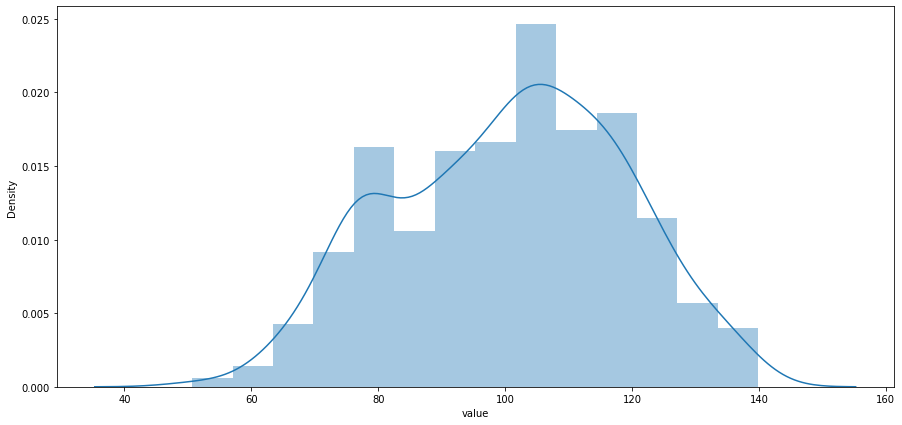

In [ ]:
sns.distplot(df['value'])

посмотрим на график самого временного ряда

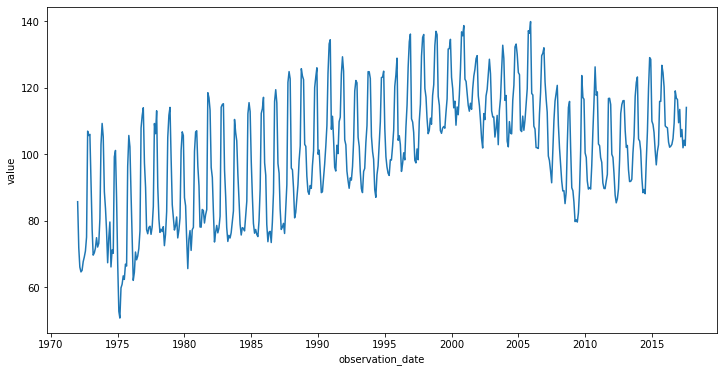

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df['value'])

Посмотрим, что нам даст группировка наблюдений по месяцам и годам.


In [ ]:
df['year'] = df.index.year
df['month'] = df.index.month
df['weekday'] = df.index.weekday


In [ ]:
df.head()

,value,year,month,WeekOfYear,weekday
observation_date,,,,,
1972-01-01,85.6945,1972,1,5,5
1972-02-01,71.8200,1972,2,1,1
1972-03-01,66.0229,1972,3,2,2
1972-04-01,64.5645,1972,4,5,5
1972-05-01,65.0100,1972,5,0,0


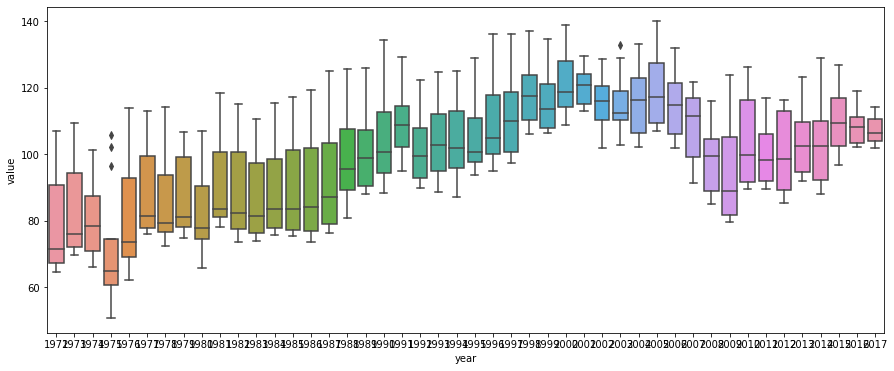

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='year', y='value', data=df)

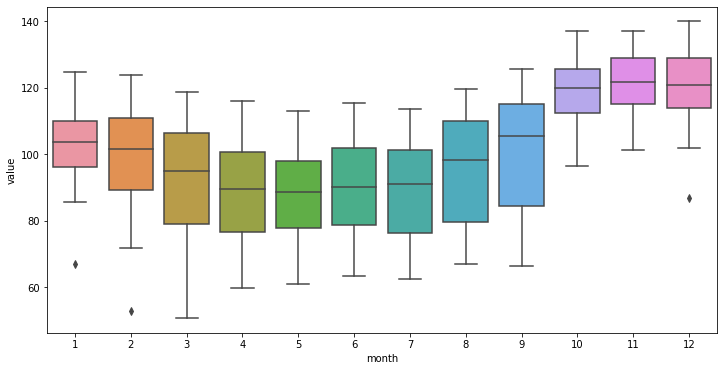

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='value', data=df)

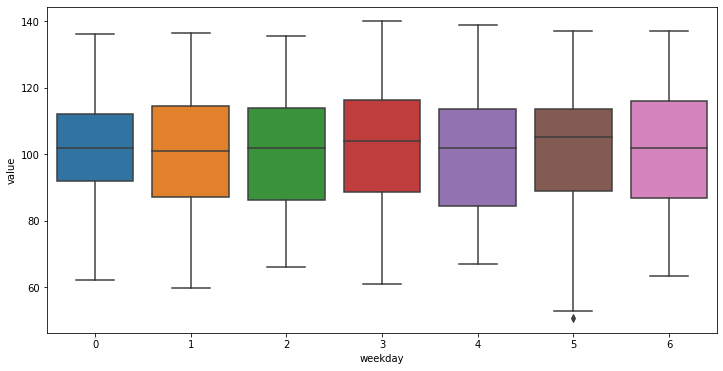

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='weekday', y='value', data=df)

создаем датафрейм для обучения

In [ ]:
prophetdf = pd.DataFrame()
prophetdf['ds'] = df.index
prophetdf['y'] = df['value'].values

Формируем обучающую и тестовую выборки (тестовую выборку выделяем в конце временного ряда)

In [ ]:
prophetdf_train = prophetdf[:-20]
prophetdf_test = prophetdf[-20:]

создаем модель для прогнозирования и обучаем ее


In [ ]:
fbmodel = fbprophet.Prophet(weekly_seasonality=False, changepoint_range=1,changepoint_prior_scale=0.75)
fbmodel.fit(prophetdf_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = fbmodel.make_future_dataframe(periods=20, freq='M')
fbforecast = fbmodel.predict(future)


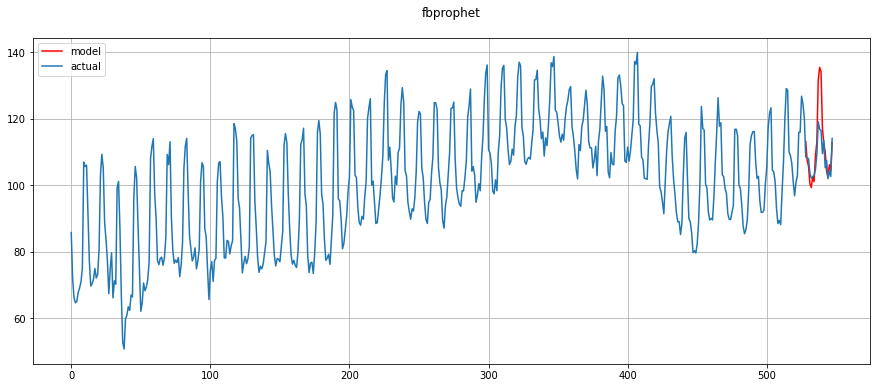

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(fbforecast.yhat[-20:], color='r', label="model")
plt.title("fbprophet\n")
plt.plot(prophetdf['y'].values[:], label="actual")

plt.legend()
plt.grid(True)

In [ ]:
mean_absolute_error(prophetdf.y[-20:], fbforecast.yhat[-20:])

4.726546379650395

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
dataset = df['value'].values


In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset1 = scaler.fit_transform(dataset.reshape(-1, 1))
len(dataset1)

548

In [ ]:
# split into train and test sets
train_size = int(len(dataset1) * 0.9)
test_size = len(dataset1) - train_size
train, test = dataset1[0:train_size], dataset1[train_size:len(dataset)]
print(len(train), len(test))

493 55


In [ ]:
def create_dataset(dataset2, look_back=1):
  dataX=[]
  dataY =[]
  for i in range(len(dataset2)-2):
    a = dataset2[i:(i+look_back)]
    dataX.append(a)
    dataY.append(dataset2[i + look_back])	
  return np.array(dataX), np.array(dataY)

In [ ]:
look_back=1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
491/491 - 2s - loss: 0.0795 - 2s/epoch - 4ms/step
Epoch 2/10
491/491 - 1s - loss: 0.0194 - 600ms/epoch - 1ms/step
Epoch 3/10
491/491 - 1s - loss: 0.0150 - 615ms/epoch - 1ms/step
Epoch 4/10
491/491 - 1s - loss: 0.0122 - 584ms/epoch - 1ms/step
Epoch 5/10
491/491 - 1s - loss: 0.0109 - 613ms/epoch - 1ms/step
Epoch 6/10
491/491 - 1s - loss: 0.0106 - 616ms/epoch - 1ms/step
Epoch 7/10
491/491 - 1s - loss: 0.0105 - 623ms/epoch - 1ms/step
Epoch 8/10
491/491 - 1s - loss: 0.0103 - 572ms/epoch - 1ms/step
Epoch 9/10
491/491 - 1s - loss: 0.0104 - 660ms/epoch - 1ms/step
Epoch 10/10
491/491 - 1s - loss: 0.0103 - 611ms/epoch - 1ms/step


In [ ]:
from sklearn.metrics import mean_squared_error
from math import *
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)


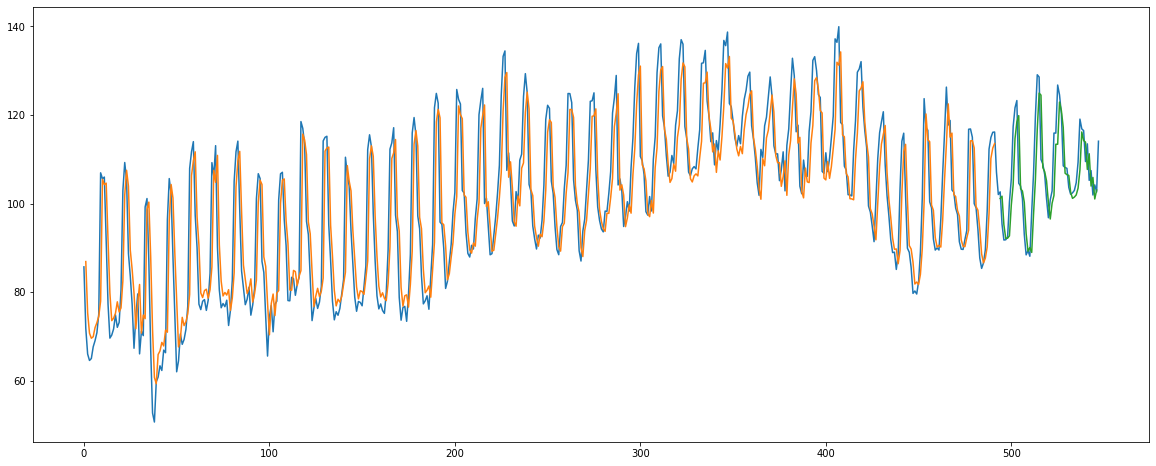

In [ ]:
plt.figure(figsize=(20, 8))
trainPredictPlot = np.empty_like(dataset1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset1)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()